### Imports and data load

In [2]:
## imports (use requirements.txt for dependencies)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import sklearn.metrics as metrics
import tensorflow as tf

2024-12-20 10:20:05.578153: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Read and show head of input data
df_input = pd.read_csv('../resources/depression_data.csv')
df_input.head()

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes


### Basic Data Checks/Cleaning
The input data is fully populated and set to reasonable data types.

The "Name" field has some duplication. In the context of the problem I have assumed this is a reflection of forename/surname pairs generated from a limited list, in a real-world situation high duplication should be checked to ensure patients are not appearing multiple times

In [4]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Name                          413768 non-null  object 
 1   Age                           413768 non-null  int64  
 2   Marital Status                413768 non-null  object 
 3   Education Level               413768 non-null  object 
 4   Number of Children            413768 non-null  int64  
 5   Smoking Status                413768 non-null  object 
 6   Physical Activity Level       413768 non-null  object 
 7   Employment Status             413768 non-null  object 
 8   Income                        413768 non-null  float64
 9   Alcohol Consumption           413768 non-null  object 
 10  Dietary Habits                413768 non-null  object 
 11  Sleep Patterns                413768 non-null  object 
 12  History of Mental Illness     413768 non-nul

In [5]:
df_input.nunique()

Name                            196851
Age                                 63
Marital Status                       4
Education Level                      5
Number of Children                   5
Smoking Status                       3
Physical Activity Level              3
Employment Status                    2
Income                          405282
Alcohol Consumption                  3
Dietary Habits                       3
Sleep Patterns                       3
History of Mental Illness            2
History of Substance Abuse           2
Family History of Depression         2
Chronic Medical Conditions           2
dtype: int64

In [6]:
df_input.duplicated().any()


False

### EDA and Feature engineering
- Name is removed as it is unlikely to be a useful predictor.
- True/False columns are converted to numerical
- Square root of income is taken to reduce right-skew
- Analysis of correlation between features

In [7]:
df_input

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413763,Sean Miller,68,Married,Master's Degree,0,Former,Moderate,Employed,109233.43,Low,Healthy,Good,No,No,No,No
413764,Christina Brown,26,Single,Bachelor's Degree,0,Current,Active,Employed,96760.97,Low,Healthy,Poor,Yes,Yes,No,Yes
413765,Matthew Jenkins,57,Married,Bachelor's Degree,0,Non-smoker,Sedentary,Employed,77353.26,Moderate,Moderate,Fair,No,No,Yes,Yes
413766,Gary Faulkner,71,Married,Associate Degree,2,Non-smoker,Sedentary,Unemployed,24557.08,Moderate,Moderate,Poor,No,Yes,No,No


In [19]:
data.loc[data['Marital Status']=='Single'].sort_values(by='Age')

,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,...,Has Children Flag,Income Square Root,Single_Over30,Single_Over40,Single_Over50,Single_Children,Divorced_Children,Widowed_Children,Poor_Lifestyle_Proxy,Unemployed_ChronicCondition
709,18,Single,High School,0,Current,Active,Employed,24127.58,High,Unhealthy,...,0,155.330551,0,0,0,0,0,0,0,0
178840,18,Single,High School,0,Non-smoker,Moderate,Unemployed,3650.55,High,Unhealthy,...,0,60.419782,0,0,0,0,0,0,0,1
178869,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,13401.65,Low,Unhealthy,...,0,115.765496,0,0,0,0,0,0,0,1
178947,18,Single,High School,0,Non-smoker,Active,Employed,36670.59,Low,Unhealthy,...,0,191.495666,0,0,0,0,0,0,0,0
178959,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,26792.07,Moderate,Unhealthy,...,0,163.682834,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397368,39,Single,High School,0,Former,Moderate,Employed,35622.01,Low,Moderate,...,0,188.737940,0,0,0,0,0,0,0,0
245621,39,Single,Bachelor's Degree,0,Former,Moderate,Employed,61873.97,Low,Moderate,...,0,248.744789,0,0,0,0,0,0,0,0
322928,39,Single,Bachelor's Degree,0,Current,Sedentary,Employed,58949.72,High,Moderate,...,0,242.795634,0,0,0,0,0,0,0,0
290561,39,Single,Master's Degree,0,Current,Sedentary,Employed,118310.71,Low,Healthy,...,0,343.963239,0,0,0,0,0,0,0,0


In [25]:
# drop 'name' as it is unlikely to be a useful feature
data = df_input.drop(['Name'], axis = 1)
# convert binary columns to numeric
data['History of Mental Illness'] = data["History of Mental Illness"].replace(('Yes', 'No'), (1, 0))
data['History of Substance Abuse'] = data["History of Substance Abuse"].replace(('Yes', 'No'), (1, 0))
data['Family History of Depression'] = data["Family History of Depression"].replace(('Yes', 'No'), (1, 0))
data['Chronic Medical Conditions'] = data["Chronic Medical Conditions"].replace(('Yes', 'No'), (1, 0))
# create children flag
data['Has Children Flag'] = data['Number of Children'].where(data['Number of Children']==0, 1)
# reduce skew in income variable
data['Income Square Root'] = np.sqrt(data['Income'])
# try interaction terms on possible useful variables
data['Divorced_Children'] = np.where((data['Marital Status']=='Divorced') & data['Has Children Flag']==1, 1, 0)
data['Widowed_Children'] = np.where((data['Marital Status']=='Widowed') & data['Has Children Flag']==1, 1, 0)
data['Unhealthy_Lifestyle_All'] = np.where((data['Alcohol Consumption']=='High')&(data['Sleep Patterns']=='Poor')&(data['Dietary Habits']=='Unhealthy')&(data['Physical Activity Level']=='Sedentary'), 1, 0)
data['Unhealthy_Lifestyle_Sum'] = np.where(data['Alcohol Consumption']=='High', 1, 0) + np.where(data['Sleep Patterns']=='Poor', 1, 0) + np.where(data['Dietary Habits']=='Unhealthy', 1, 0) + np.where(data['Physical Activity Level']=='Sedentary', 1, 0) + np.where(data['Smoking Status']=='Current', 1, 0)
data['Unemployed_ChronicCondition'] = np.where((data['Employment Status']=='Unemployed')&(data['Chronic Medical Conditions']==1), 1, 0)

data.describe(include='all').T

/var/folders/gs/zrjdwm714r1fpj6csntklm3m0000gn/T/ipykernel_29123/3674976057.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['History of Mental Illness'] = data["History of Mental Illness"].replace(('Yes', 'No'), (1, 0))
/var/folders/gs/zrjdwm714r1fpj6csntklm3m0000gn/T/ipykernel_29123/3674976057.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['History of Substance Abuse'] = data["History of Substance Abuse"].replace(('Yes', 'No'), (1, 0))
/var/folders/gs/zrjdwm714r1fpj6csntklm3m0000gn/T/ipykernel_29123/3674976057.

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,413768.0,NaN,NaN,NaN,49.000713,18.158759,18.0,33.0,49.0,65.0,80.0
Marital Status,413768,4,Married,240444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education Level,413768,5,Bachelor's Degree,124329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number of Children,413768.0,NaN,NaN,NaN,1.298972,1.237054,0.0,0.0,1.0,2.0,4.0
Smoking Status,413768,3,Non-smoker,247416,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Physical Activity Level,413768,3,Sedentary,176850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Employment Status,413768,2,Employed,265659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income,413768.0,NaN,NaN,NaN,50661.707971,40624.100565,0.41,21001.03,37520.135,76616.3,209995.22
Alcohol Consumption,413768,3,Moderate,173440,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dietary Habits,413768,3,Unhealthy,170817,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
cat_cols=data.select_dtypes(include=['object']).columns
num_cols = data.select_dtypes(include=np.number).columns.tolist()

### Review distribution and skew of numeric features

Age
Skew : 0.0


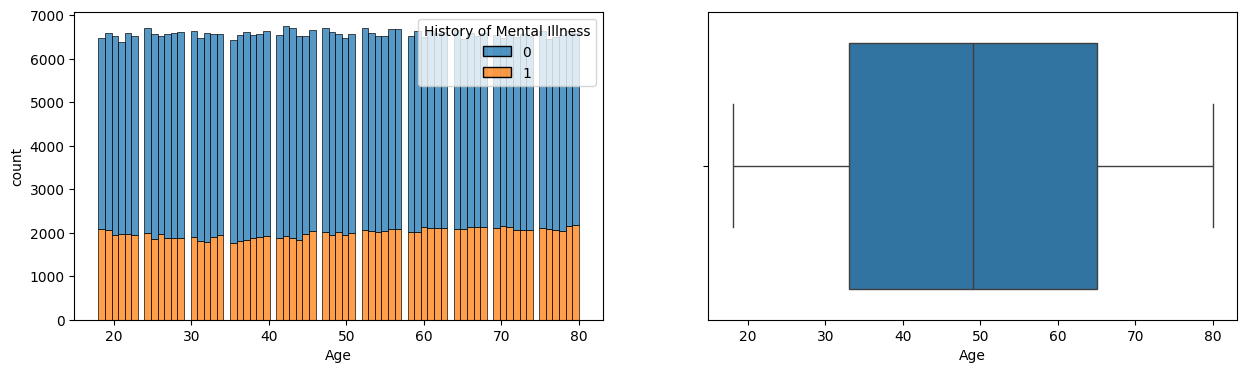

Number of Children
Skew : 0.43


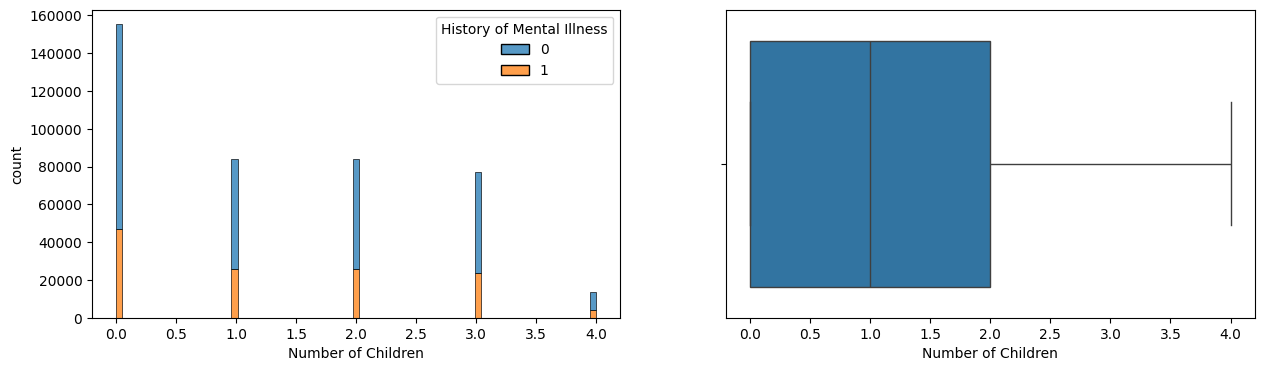

Income
Skew : 1.09


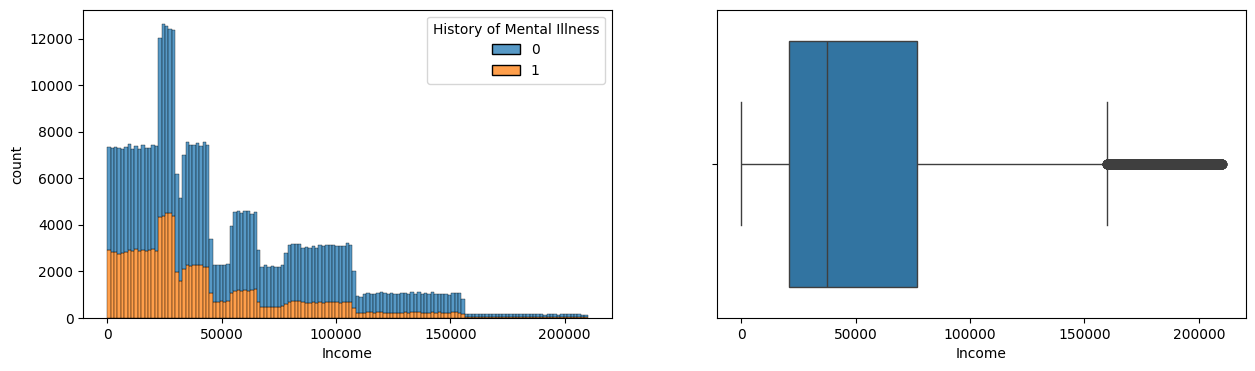

History of Mental Illness
Skew : 0.85


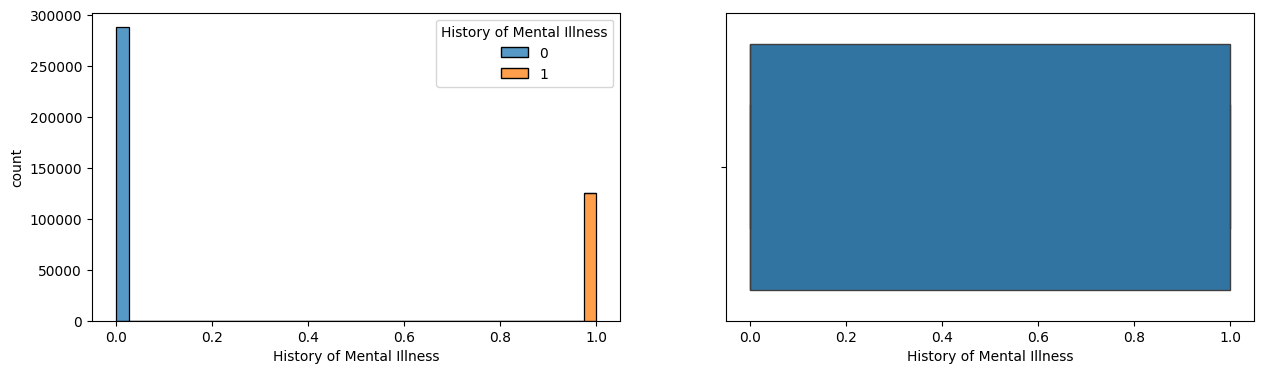

History of Substance Abuse
Skew : 0.81


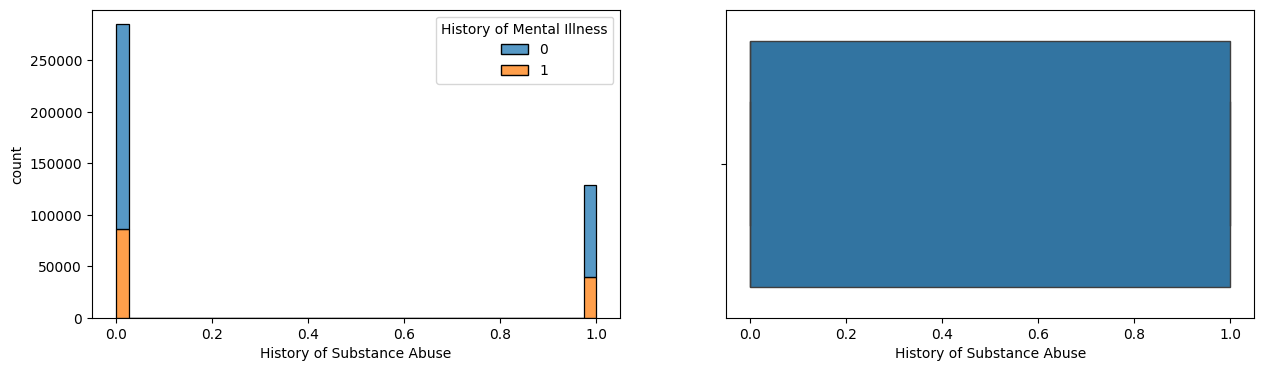

Family History of Depression
Skew : 1.04


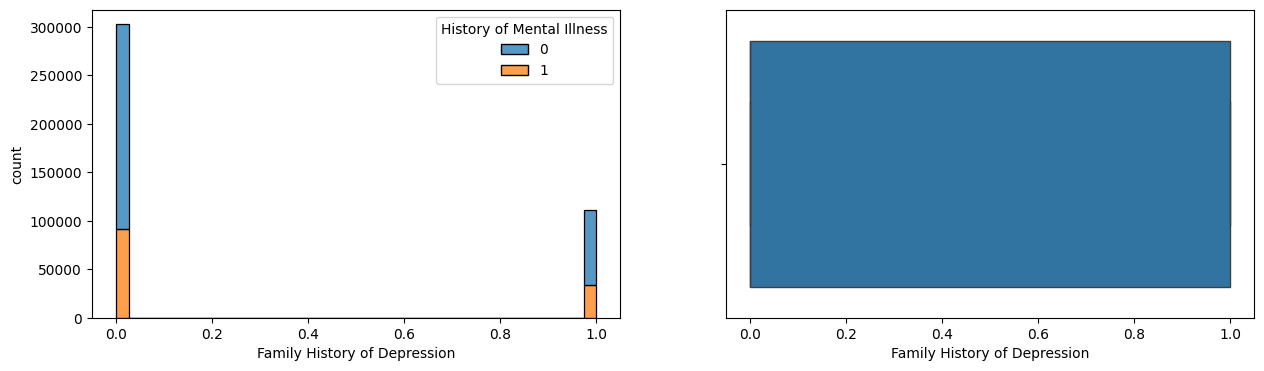

Chronic Medical Conditions
Skew : 0.73


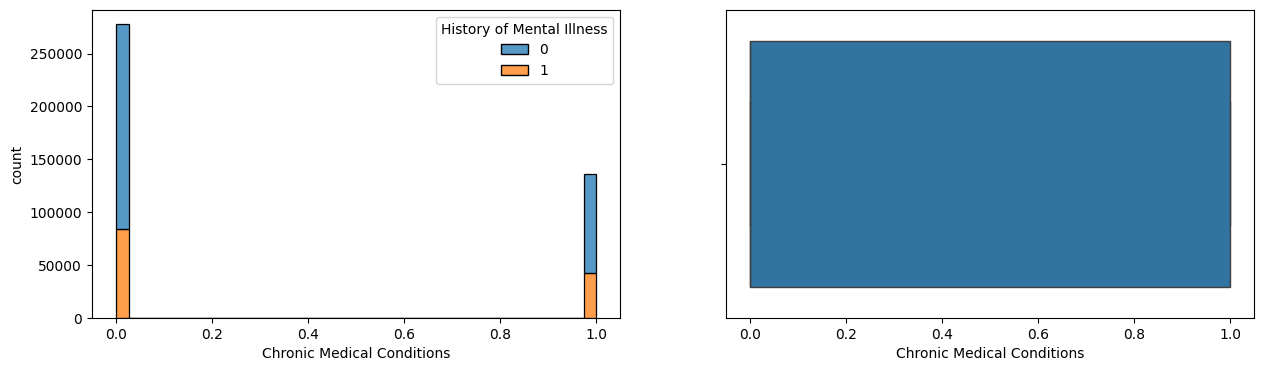

Has Children Flag
Skew : -0.52


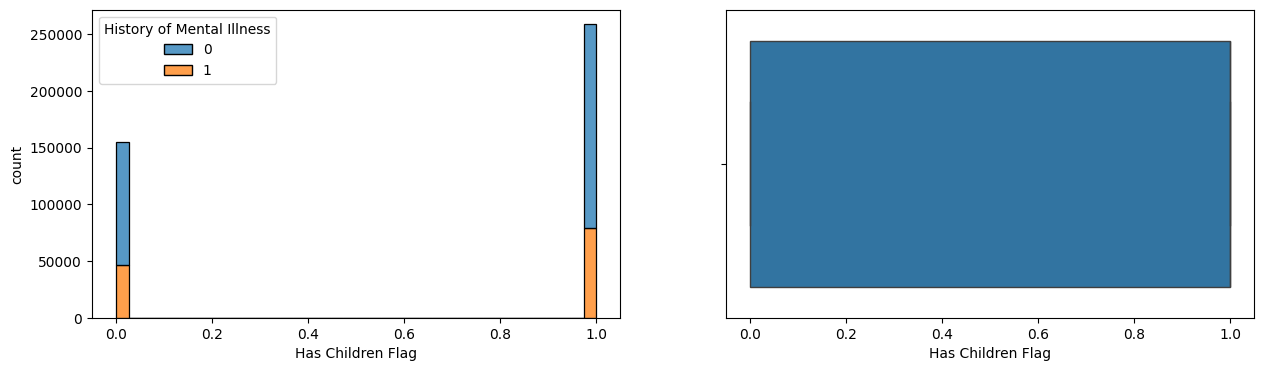

Income Square Root
Skew : 0.26


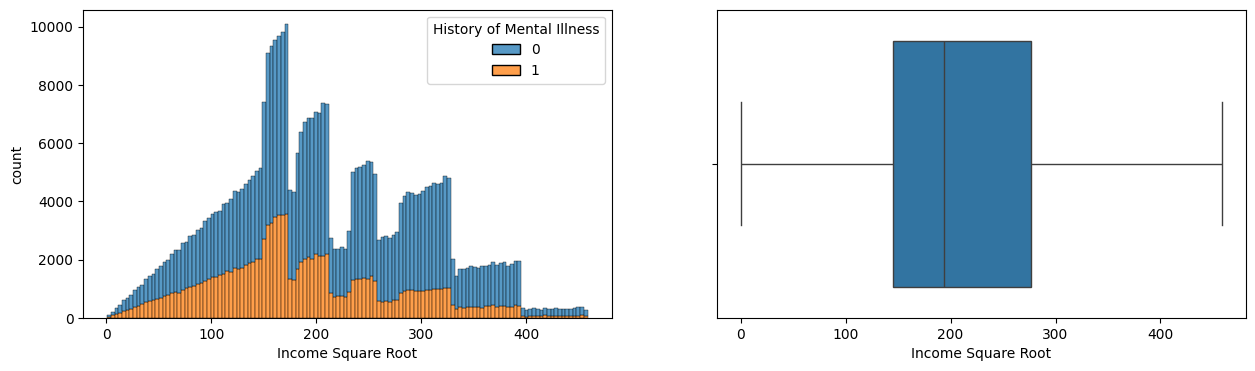

Divorced_Children
Skew : 3.72


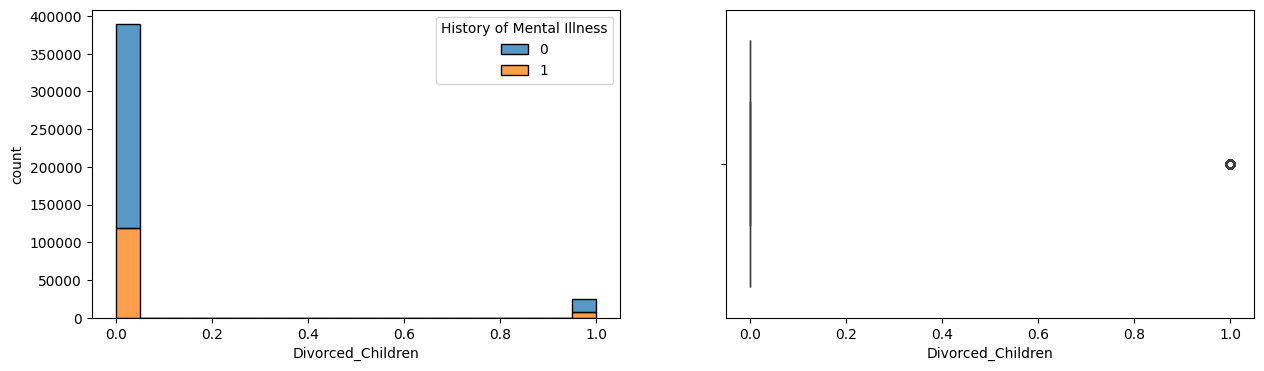

Widowed_Children
Skew : 2.28


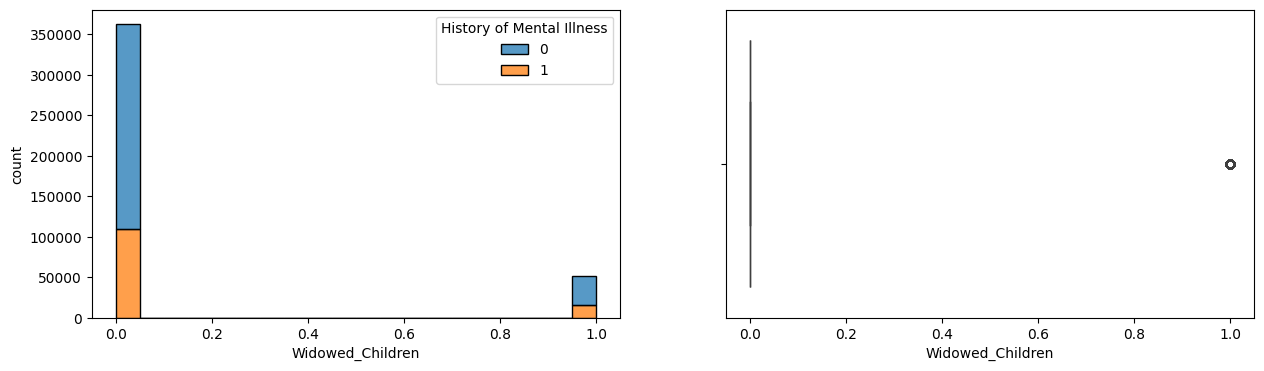

Unhealthy_Lifestyle_All
Skew : 6.12


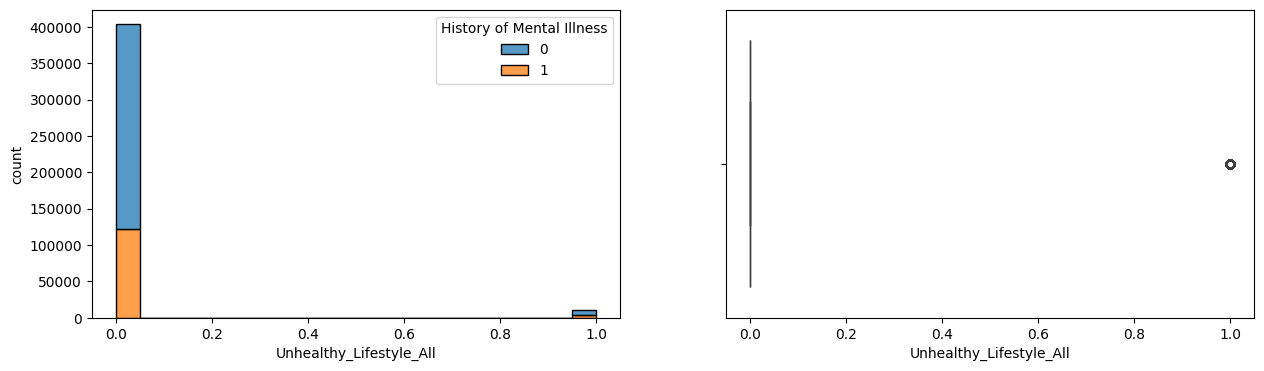

Unhealthy_Lifestyle_Sum
Skew : 0.34


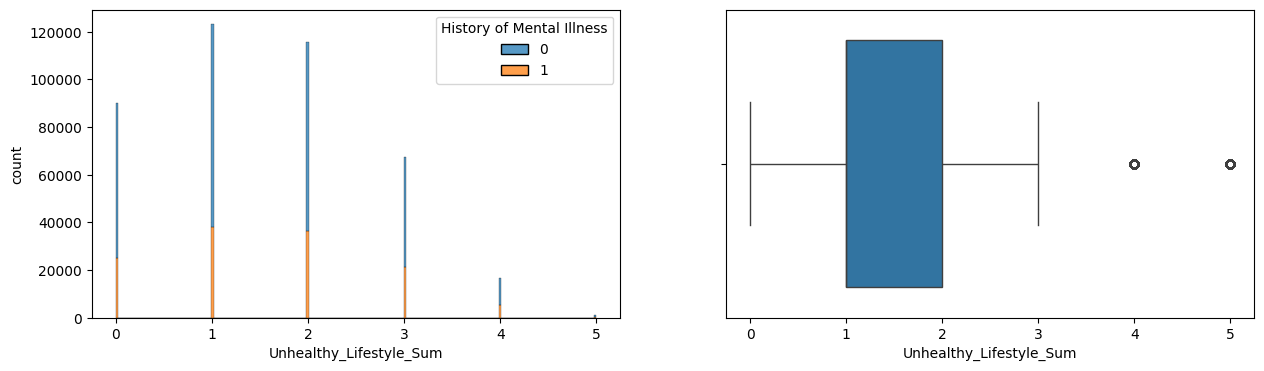

Unemployed_ChronicCondition
Skew : 2.24


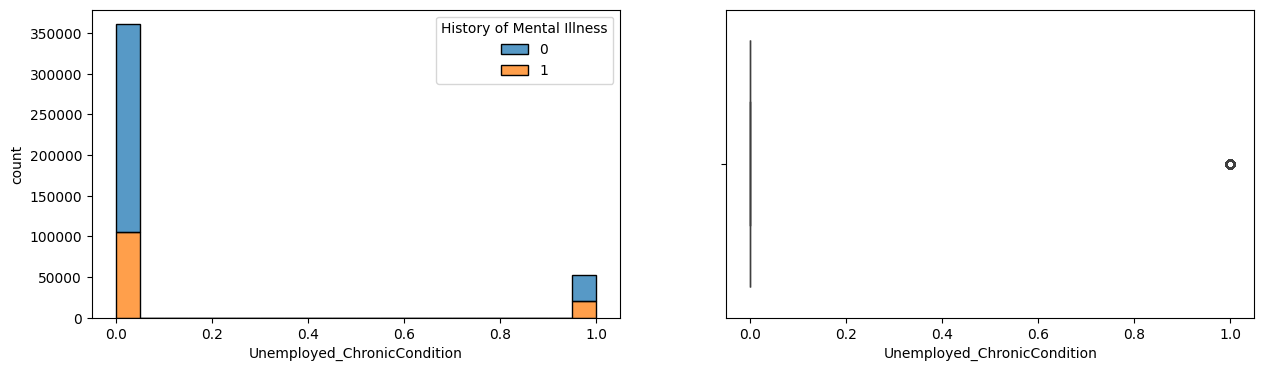

In [27]:
for col in num_cols:
    print(col)
    print('Skew :', round(data[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    # data[col].hist(grid=False)
    sns.histplot(bins='auto', x = col, hue="History of Mental Illness", data=data, multiple='stack');
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.show()

### Review bar plots of categorical features

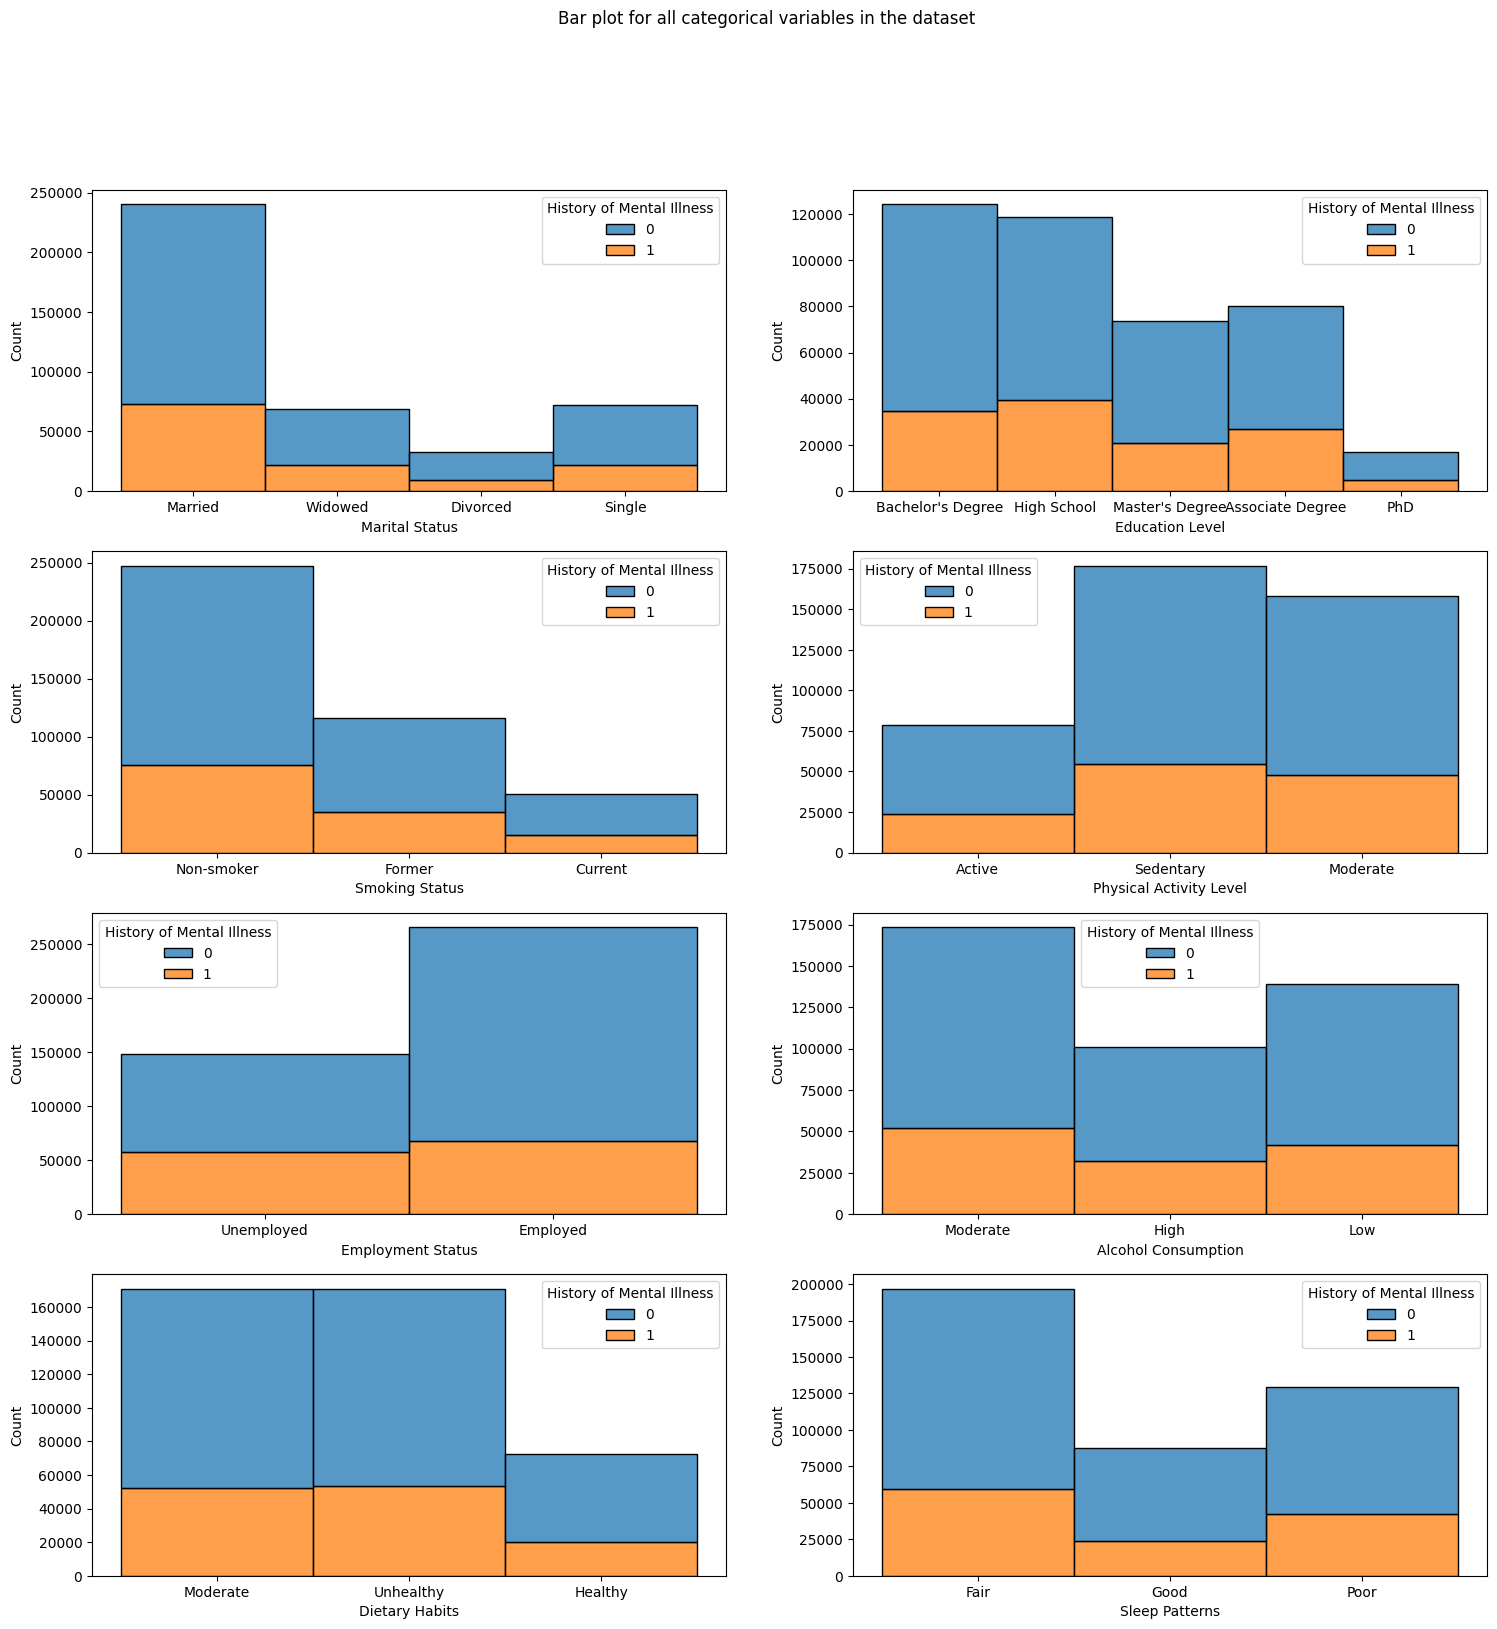

In [28]:
fig, axes = plt.subplots(4, 2, figsize = (18, 18))
fig.suptitle('Bar plot for all categorical variables in the dataset')
for i, col in enumerate(cat_cols):
    sns.histplot(ax = axes[i//2, i%2], binwidth=0.5, x = col, hue="History of Mental Illness", data=data, multiple='stack');

### Review correlation between numerical variables

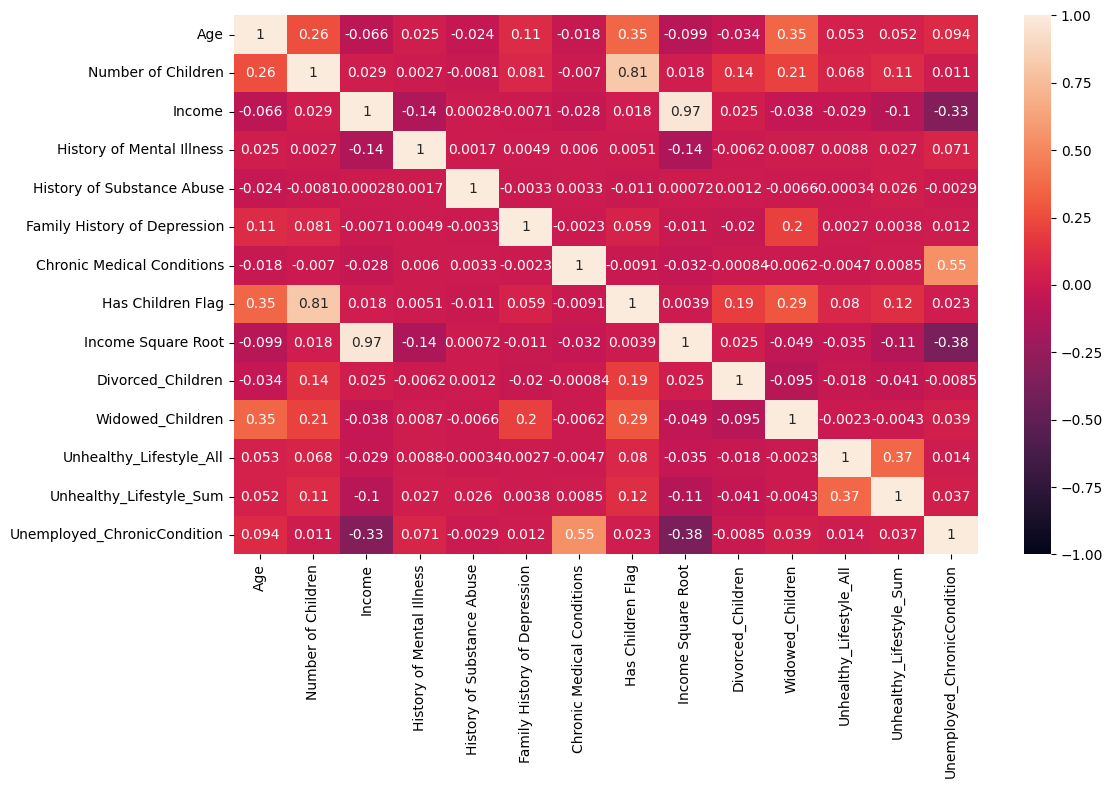

In [29]:
plt.figure(figsize=(12, 7))
sns.heatmap(data[num_cols].corr(), annot = True, vmin = -1, vmax = 1)
plt.show()

### Review correlation to the target variable and select features
- A full feature set is created based only on removing features with high cross-correlation
- A 'reduced features' set is created based on removing variables with low correlation to the target (<0.1), with the aim of preserving performance whilst reducing complexity|

In [30]:
# one hot encode categorical features
data_onehot = pd.get_dummies(data)

In [31]:
data_onehot[data_onehot.columns[1:]].corr()['History of Mental Illness'][:]

Number of Children                   0.002713
Income                              -0.136805
History of Mental Illness            1.000000
History of Substance Abuse           0.001733
Family History of Depression         0.004887
Chronic Medical Conditions           0.006038
Has Children Flag                    0.005147
Income Square Root                  -0.143059
Divorced_Children                   -0.006201
Widowed_Children                     0.008714
Unhealthy_Lifestyle_All              0.008779
Unhealthy_Lifestyle_Sum              0.027339
Unemployed_ChronicCondition          0.071247
Marital Status_Divorced             -0.006516
Marital Status_Married               0.001821
Marital Status_Single               -0.007040
Marital Status_Widowed               0.009500
Education Level_Associate Degree     0.031231
Education Level_Bachelor's Degree   -0.038089
Education Level_High School          0.036902
Education Level_Master's Degree     -0.024371
Education Level_PhD               

In [ ]:
features = [
    'Age',
    'Marital Status',
    'Education Level',
    # 'Number of Children',
    # 'Income',
    'Smoking Status', 
    'Physical Activity Level',
    'Employment Status',
    'Alcohol Consumption',
    'Dietary Habits',
    'Sleep Patterns',
    'History of Substance Abuse',
    'Family History of Depression',
    'Chronic Medical Conditions',
    'Has Children Flag',
    'Income Square Root', 
    'Divorced_Children',
    'Widowed_Children', 
    'Unhealthy_Lifestyle_All',
    'Unhealthy_Lifestyle_Sum', 
    'Unemployed_ChronicCondition'
]
target = 'History of Mental Illness'

In [ ]:
features_reduced = [
    'Age',
    # 'Marital Status',
    'Education Level',
    # 'Number of Children',
    # 'Income',
    # 'Smoking Status', 
    # 'Physical Activity Level',
    'Employment Status',
    'Alcohol Consumption',
    'Dietary Habits',
    'Sleep Patterns',
    # 'History of Substance Abuse',
    # 'Family History of Depression',
    # 'Chronic Medical Conditions',
    # 'Has Children Flag',
    'Income Square Root', 
    # 'Divorced_Children',
    # 'Widowed_Children', 
    'Unhealthy_Lifestyle_All',
    'Unhealthy_Lifestyle_Sum', 
    'Unemployed_ChronicCondition'    
]

## Modelling Exploration
- Trialling Logistic Regression and XGBoost approaches with all features

In [ ]:
# categorical data inputs
for c in data.columns:
    if data[c].dtype == 'object':
        data[c] = data[c].astype('category')

Xcat = data[features]
ycat = data[target]

Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(Xcat, ycat, test_size=0.2)

In [42]:
# one-hot-encoded data inputs
X = pd.get_dummies(Xcat)

X_train, X_test, y_train, y_test = train_test_split(X, ycat, test_size=0.2)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [43]:
# function to rapidly evaluate a candidate model
def quick_eval(mdl, X_t, y_t, nn=False):
    if nn:
        prob = mdl.predict(X_t)
        pred = [1 if e>0.5 else 0 for e in prob]
    else:
        pred = mdl.predict(X_t)
        prob = mdl.predict_proba(X_t)[:,1]
    print('Accuracy:', metrics.accuracy_score(y_t, pred))
    print('Precision:', metrics.precision_score(y_t, pred))
    print('Recall:', metrics.recall_score(y_t, pred))
    print('F1 Score:', metrics.f1_score(y_t, pred))

    fpr, tpr, thresholds = metrics.roc_curve(y_t, prob)
    roc_auc = metrics.auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    if not nn:
        display = metrics.PrecisionRecallDisplay.from_estimator(
            mdl, X_t, y_t, name="LinearSVC", plot_chance_level=True
        )
        _ = display.ax_.set_title("2-class Precision-Recall curve")
        plt.show()
    

Accuracy: 0.6972110109481112
Precision: 0.0
Recall: 0.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1 Score: 0.0


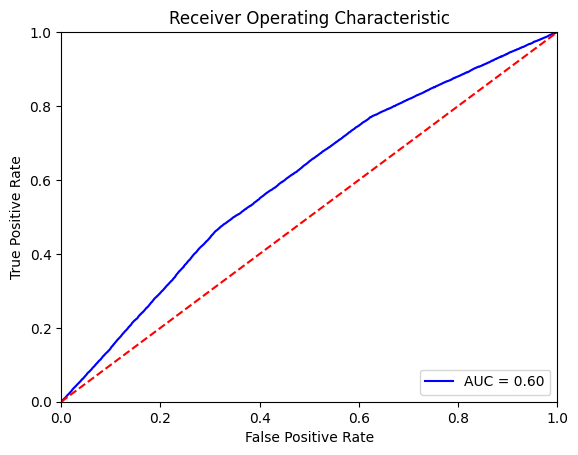

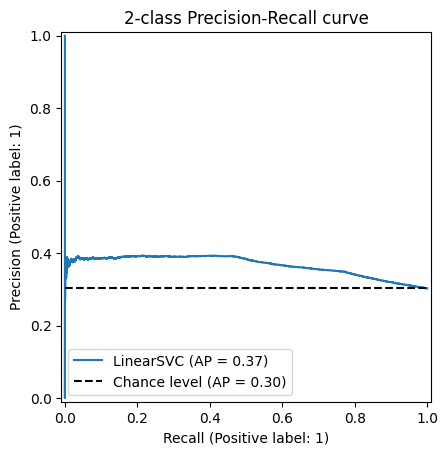

In [44]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

quick_eval(log_reg, X_test, y_test)

Accuracy: 0.6953379897044252
Precision: 0.411864406779661
Recall: 0.009678190218257129
F1 Score: 0.018911977585804342


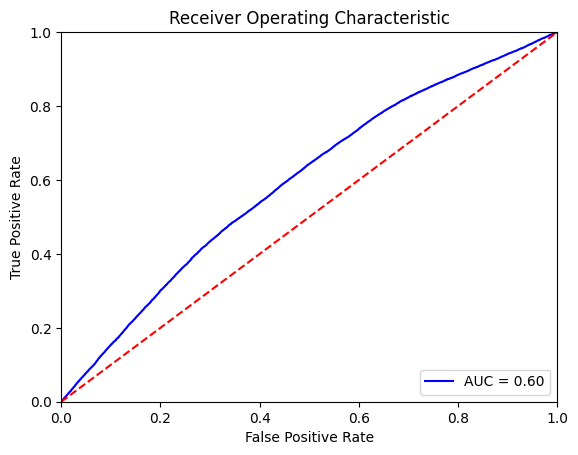

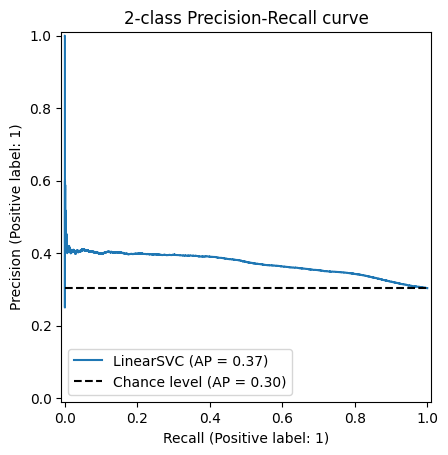

In [38]:
xgb = XGBClassifier(enable_categorical=True)
xgb.fit(Xcat_train, ycat_train)

quick_eval(xgb, Xcat_test, ycat_test)

Accuracy: 0.6449718442613046
Precision: 0.3451048162897288
Recall: 0.181850576077919
F1 Score: 0.23818907846289478


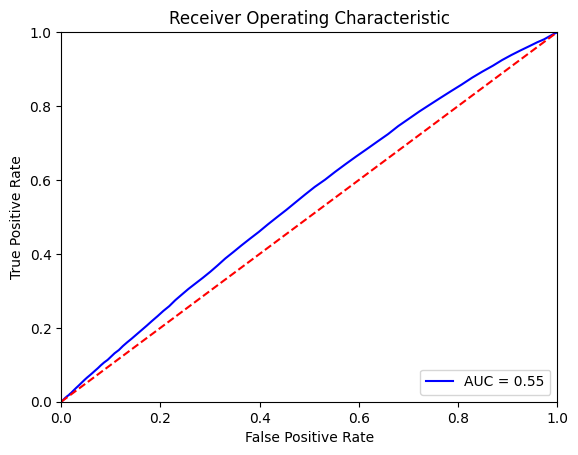

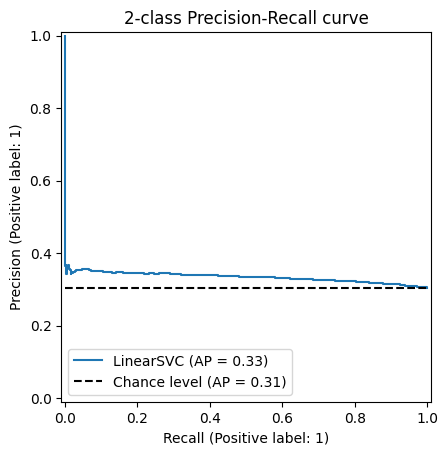

In [39]:
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)

quick_eval(rnd_clf, X_test, y_test)

In [21]:
model = tf.keras.Sequential([
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(128, activation="relu"),
                  tf.keras.layers.Dense(1, activation="sigmoid")
 ])
# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])
# Fit the model
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_test, y_test))

model.evaluate(X_test, y_test)

Epoch 1/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.6928 - loss: 0.6056 - val_accuracy: 0.6955 - val_loss: 0.6018
Epoch 2/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.6953 - loss: 0.6015 - val_accuracy: 0.6955 - val_loss: 0.6013
Epoch 3/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.6965 - loss: 0.5996 - val_accuracy: 0.6955 - val_loss: 0.6014
Epoch 4/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6956 - loss: 0.6002 - val_accuracy: 0.6955 - val_loss: 0.6016
Epoch 5/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.6958 - loss: 0.6002 - val_accuracy: 0.6955 - val_loss: 0.6014
Epoch 6/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.6971 - loss: 0.5987 - val_accuracy: 0.6955 - val_loss: 0.6009
Epoch 7/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.6951 - loss: 0.6005 - val_accuracy: 0.6955 - val_loss: 0.6011
Epoch 8/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 

[0.6036379337310791, 0.6946975588798523]

2587/2587 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Accuracy: 0.6946975372791647
Precision: 0.3443396226415094
Recall: 0.002896940354775983
F1 Score: 0.005745543268663177


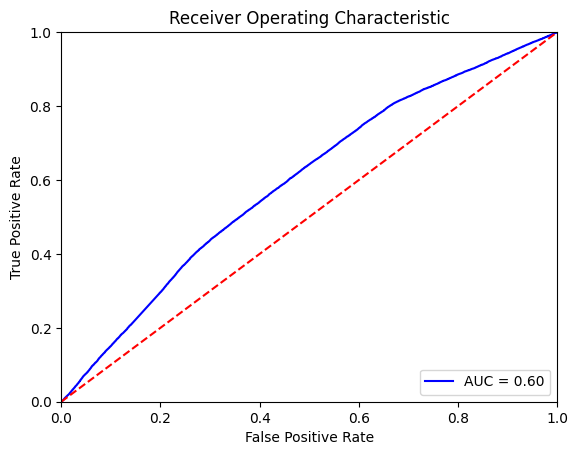

In [22]:
quick_eval(model, X_test, y_test, nn=True)

### Training and evaluating a Logistic Regression
- Does a LR perform worse on a reduced feature set?

In [47]:
# categorical data inputs
for c in data.columns:
    if data[c].dtype == 'object':
        data[c] = data[c].astype('category')

Xcat = data[features_reduced]
ycat = data[target]

Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(Xcat, ycat, test_size=0.2)

In [46]:
# one-hot-encoded data inputs
X = pd.get_dummies(Xcat)

X_train, X_test, y_train, y_test = train_test_split(X, ycat, test_size=0.2)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Accuracy: 0.6957730139932813
Precision: 0.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall: 0.0
F1 Score: 0.0


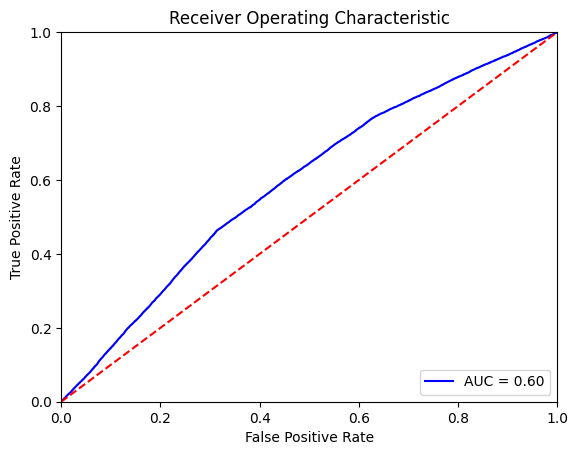

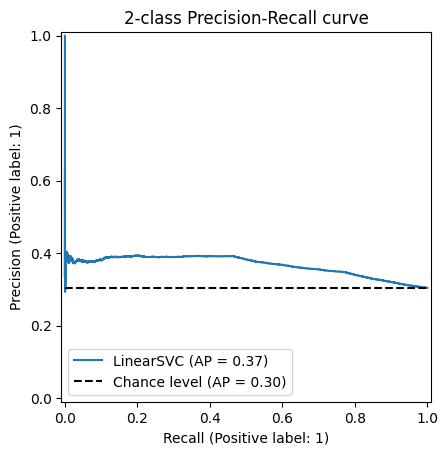

In [49]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

quick_eval(log_reg, X_test, y_test)

In [59]:
prob = log_reg.predict_proba(X_test)[:,1]
pred = y_pred = (prob >= 0.3).astype('int')

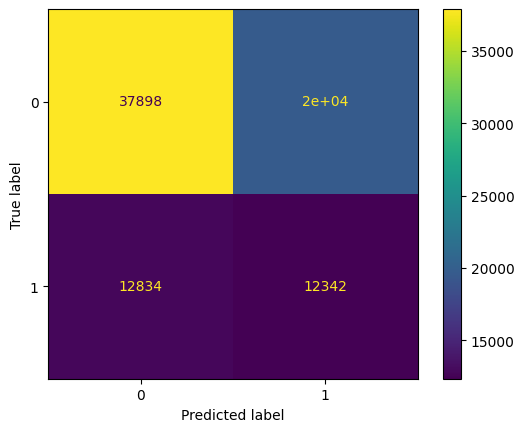

In [60]:
confusion_matrix = metrics.confusion_matrix(y_test,pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [61]:
print(f'Precision: {metrics.precision_score(y_test, pred)}')
print(f'Recall: {metrics.recall_score(y_test, pred)}')
print(f'Accuracy: {metrics.accuracy_score(y_test, pred)}')

Precision: 0.38542252201611393
Recall: 0.49022878932316494
Accuracy: 0.6071005631147739


In [72]:
X_train

array([[-0.99181878, -0.1042484 , -0.15963777, ..., -0.9522524 ,
         1.93450793, -0.67588847],
       [-0.33058229, -0.58462247, -0.15963777, ..., -0.9522524 ,
         1.93450793, -0.67588847],
       [ 1.48781806, -0.48489435, -0.15963777, ...,  1.05014174,
        -0.51692732, -0.67588847],
       ...,
       [-0.33058229,  1.88362475, -0.15963777, ..., -0.9522524 ,
        -0.51692732,  1.47953404],
       [-0.8816127 ,  0.32697355, -0.15963777, ..., -0.9522524 ,
        -0.51692732,  1.47953404],
       [ 0.77147853, -1.06119501, -0.15963777, ..., -0.9522524 ,
         1.93450793, -0.67588847]])

In [ ]:
pd.DataFrame({'Feature':pd.get_dummies(data[features_reduced]).columns,
              'Coefficient':log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'